In [1]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/data"

/content/drive/MyDrive/Colab Notebooks/data


In [3]:
# Downloading tokenization script created by the Google
#!wget --quiet https://github.com/google-research/bert/blob/master/tokenization.py

In [4]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 19.0 MB/s 


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split

import tokenization

In [14]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [15]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    
    return model

In [8]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 22.5 s, sys: 5.24 s, total: 27.7 s
Wall time: 1min 11s


In [9]:
val = pd.read_json("dev.jsonl",lines=True)
train = pd.read_json("train.jsonl",lines=True)
test = pd.read_json("test.jsonl",lines=True)

In [10]:
val.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [11]:
y_train = train["label"]
X_train = train["text"]
#Y_test = test.pop("label")
#X_test= test
y_test = val["label"]
X_test= val["text"]

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(FMS.textNdesc, FMS.label, test_size=0.2, random_state=42)

In [12]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [16]:
train_input = bert_encode(X_train.values, tokenizer, max_len=160)
test_input = bert_encode(X_test.values, tokenizer, max_len=160)
train_labels = y_train.values

In [17]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

8500 500 8500 500


In [18]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 160, 1024)]               'input_mask[0][0]',         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
from keras import backend as K
K.clear_session()

In [20]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
                    
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.3,
    epochs=30,
    callbacks=[checkpoint],
    batch_size=8,
    steps_per_epoch=12
)

Epoch 1/30
12/12 [==============================] - 142s 10s/step - loss: 0.6822 - accuracy: 0.6458 - auc: 0.4526 - val_loss: 0.6755 - val_accuracy: 0.5937 - val_auc: 0.5262
Epoch 2/30
12/12 [==============================] - 112s 10s/step - loss: 0.6747 - accuracy: 0.5938 - auc: 0.5823 - val_loss: 0.6604 - val_accuracy: 0.6078 - val_auc: 0.5810
Epoch 3/30
12/12 [==============================] - 111s 10s/step - loss: 0.6829 - accuracy: 0.5625 - auc: 0.5266 - val_loss: 0.6462 - val_accuracy: 0.6263 - val_auc: 0.6408
Epoch 4/30
12/12 [==============================] - 99s 9s/step - loss: 0.6292 - accuracy: 0.6458 - auc: 0.6637 - val_loss: 0.6616 - val_accuracy: 0.6098 - val_auc: 0.6403
Epoch 5/30
12/12 [==============================] - 98s 9s/step - loss: 0.6649 - accuracy: 0.6250 - auc: 0.5706 - val_loss: 0.6492 - val_accuracy: 0.6145 - val_auc: 0.6430
Epoch 6/30
12/12 [==============================] - 143s 13s/step - loss: 0.6023 - accuracy: 0.7188 - auc: 0.6259 - val_loss: 0.6428 -

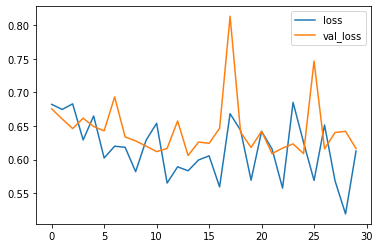

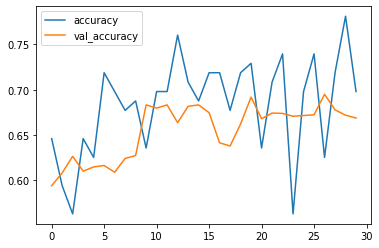

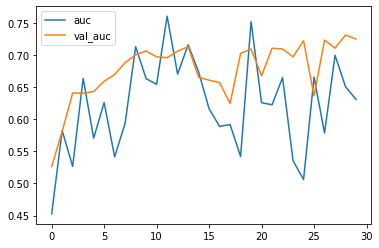

In [21]:
history_frame = pd.DataFrame(train_history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
history_frame.loc[:, ['auc', 'val_auc']].plot()

In [22]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

16/16 [==============================] - 19s 1s/step


In [23]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

In [24]:
y_actual = list(y_test)
y_prob = list(test_pred.reshape(len(test_pred), ))

In [25]:
print("AUC: ", roc_auc_score(y_actual, y_prob))

AUC:  0.62544


In [26]:
def threshold(i, th):
    if i > th:
        return 1
    else:
        return 0

def select_threshold(y_actual, y_prob):
    acc = 0.5
    selected_th = 0
    for th in np.arange(0, 1, 0.005):
        y_predicted = [threshold(i, th) for i in y_prob]
        if balanced_accuracy_score(y_actual, y_predicted) > acc:
            acc = balanced_accuracy_score(y_actual, y_predicted)
            selected_th = th
    return selected_th

th = select_threshold(y_actual, y_prob)
y_predicted = [threshold(i, th) for i in y_prob]

In [27]:
print("Accuracy: ", balanced_accuracy_score(y_actual, y_predicted))

Accuracy:  0.5880000000000001
